# CS 51 Final Project Interface

By: Olivia Angiuli, Martin Reindl, Ty Rocca, Wilder Wohns

**Purpose:** This top level iPython notebook is designed to be a place to see how our code works. It is also a good way for us to show off our results

In [1]:
#!/usr/bin/env python

In [31]:
import numpy as np
import os, struct,random #,
# import sys
from numpy import append, array, int8, uint8, zeros

# import modules
import Initialize, Accuracy, Distance, File, Kmeans, ClassifyClusters

import base64
import json
import timeit

######################################
# Load in training images and labels #
######################################

# load training and testing images and labels as 60,000 x 28 x 28 array
train_images,train_labels = File.load_mnist("training",path=os.getcwd(), prop = 5)
test_images,test_labels = File.load_mnist("testing",path=os.getcwd())

# flatten training images into 60,000 x 784 array
train_images_flat = np.array([np.ravel(img) for img in train_images])
test_images_flat = np.array([np.ravel(img) for img in test_images])

def main (k, m="means", init_type="random"):
    
    # Starting clustering timer
    start_cluster = timeit.default_timer()
    
    # Process arguments
    if k < 10:
        raise ValueError("Minimum cluster number is 10")
    
    #Process method of clustering
    if m not in ["means", "medoids", "medians"]:
        raise ValueError("Not a valid method specification; must be 'means',\
          'medoids', or 'medians'")
    
    # Method for clustering
    initial_clusters = None
    if init_type == "random":
        initial_clusters = Initialize.random_centers(k)
    else:
        init_type = "kplusplus"
        initial_clusters = Initialize.kmeans_plusplus(k, train_images_flat,
                                           dist_fn=Distance.sumsq)
        
        
        
    # Run clustering algorithm
    final_responsibilities, final_clusters = Kmeans.kmeans(k, train_images_flat,
        initial_clusters, distfn = Distance.sumsq, method=m)
    
    # Output of results
    print final_responsibilities.sum(axis=0)

    # Time to cluster
    end_cluster = timeit.default_timer()
    clustering_time = end_cluster - start_cluster
    print "Time spent clustering : ", clustering_time


    # Save representative images to file.
    title = m + "_" + init_type + "_cluster" + str(k)
    Load.save_images(k, train_images, final_responsibilities, 
                     final_clusters, title)

    # Calculate final accuracy for clusters
    final, cluster_set = Accuracy.final_accuracy(final_responsibilities, 
        train_labels, train_images_flat, final_clusters)

    # Now see how well we can classify the dataset
    start_cluster_test = timeit.default_timer()
    predictions = ClassifyClusters.classify(cluster_set, test_images_flat, 
        test_labels, distfn = Distance.sumsq, n=None)
    finish_cluster_test = timeit.default_timer()

    testing_time = finish_cluster_test - start_cluster_test
    print "Time spent testing : ", testing_time
    
    ###########
    # Outputs #
    ###########

    # Serializing numpy array - from below source 
    # http://stackoverflow.com/questions/3488934/simplejson-and-numpy-array
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            """
            if input object is a ndarray it will be converted into a 
            dict holding dtype, shape and the data base64 encoded
            """
            if isinstance(obj, np.ndarray):
                data_b64 = base64.b64encode(obj.data)
                return dict(__ndarray__=data_b64,
                            dtype=str(obj.dtype),
                            shape=obj.shape)
            # Let the base class default method raise the TypeError
            return json.JSONEncoder(self, obj)


    def json_numpy_obj_hook(dct):
        """
        Decodes a previously encoded numpy ndarray
        with proper shape and dtype
        :param dct: (dict) json encoded ndarray
        :return: (ndarray) if input was an encoded ndarray
        """
        if isinstance(dct, dict) and '__ndarray__' in dct:
            data = base64.b64decode(dct['__ndarray__'])
            return np.frombuffer(data, dct['dtype']).reshape(dct['shape'])
        return dct


    # k, prediction level, cluster_set, 
    results = {"k" : k, "prediction_accuracy" : predictions[1], 
    "cluster_means" : cluster_set, "cluster_stats" : final,
    "clustering_time" : clustering_time, "testing_time" : testing_time}


#     with open('./' + title + '/' + title + '_results.json', 'w') as outfile:
#         json.dump(results, outfile, cls=NumpyEncoder)


ImportError: No module named File

In [6]:
####################
# Call to function #
####################
# main(10, m="medians", init_type="k_plus_plus")

# k = 9
# for k in testing_ks:
#     print "nohup python main_cluster.py {k} {method} {init_type} {prop} > {method}_{init_type}_cluster{k}.out &".format(k = k,
#                                                                         method = m,
#                                                                         init_type =init_type,
#                                                                         prop = 5)

In [47]:
# How to load the data back in from files:
# json.loads(dumped, object_hook=json_numpy_obj_hook)

# source : http://stackoverflow.com/questions/3488934/simplejson-and-numpy-array/24375113#24375113
import base64
import json
import numpy as np

def json_numpy_obj_hook(dct):
        """
        Decodes a previously encoded numpy ndarray
        with proper shape and dtype
        :param dct: (dict) json encoded ndarray
        :return: (ndarray) if input was an encoded ndarray
        """
        if isinstance(dct, dict) and '__ndarray__' in dct:
            data = base64.b64decode(dct['__ndarray__'])
            return np.frombuffer(data, dct['dtype']).reshape(dct['shape'])
        return dct


In [111]:
# All of the options we tested:

testing_ks = range(10,20) + range(20, 55, 5)
methods = ["means", "medoids", "medians"]
init_types = ["random", "kplusplus"]

# Results appended to df
results_set = []
for k in testing_ks:
    for m in methods:
        for init_type in init_types:
            title = m + "_" + init_type + "_cluster" + str(k)
            with open('./' + title + '/' + title + '_results.json') as data_file:
                json_in = json.load(data_file,object_hook=json_numpy_obj_hook)
                json_in["method"] = m
                json_in["init_type"] = init_type
                json_in["title"] = title
                results_set.append(json_in)
import pandas as pd
results_df = pd.DataFrame(results_set)

In [112]:
# reformat column names
results_df = results_df[[u'method', u'init_type', u'k', 
                         u'prediction_accuracy', u'clustering_time', 
                         u'testing_time', u'cluster_means', 
                        u'cluster_stats', u"title"]]


In [113]:
# Here is the head of the output of our code
results_df.head()

,method,init_type,k,prediction_accuracy,clustering_time,testing_time,cluster_means,cluster_stats,title
0,means,random,10,59.465947,6564.869596,22.154983,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.858911697621, 1694.73068149, 6138.0],...",means_random_cluster10
1,means,kplusplus,10,59.575958,6359.469025,27.613850,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.944126402565, 1745.659018, 4367.0], [...",means_kplusplus_cluster10
2,medoids,random,10,44.614461,374.554019,25.656851,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.812128662159, 2168.16810076, 4881.0],...",medoids_random_cluster10
3,medoids,kplusplus,10,48.364836,1159.850245,65.437160,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.662012578616, 2106.44993705, 7950.0],...",medoids_kplusplus_cluster10
4,medians,random,10,55.965597,8419.787714,24.625500,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.907110318875, 2011.71413908, 5049.0],...",medians_random_cluster10


In [150]:
# Now we plot our dataset
# Here is the function to make plots

%matplotlib inline
import matplotlib.pyplot as plt

def plotset (xdata, ydata, title, labels=[False]):
    
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(xdata, ydata, marker = 'o', c ="blue", s = 100)
    if labels[0]:
        labels = labels[1]
        for label, x, y in zip(labels, xdata, ydata):
            plt.annotate(
                label, 
                xy = (x, y), xytext = (-20, 20),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    plt.suptitle(title)
    title = title.split(" vs. ")
    plt.ylabel(title[0])
    plt.xlabel(title[1].split(" for")[0])
    plt.show()

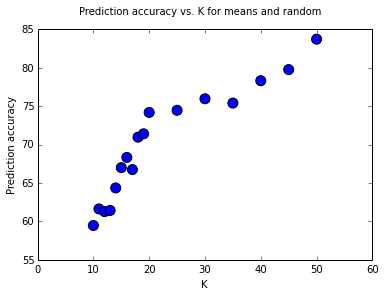

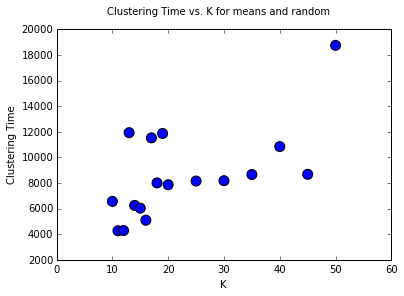

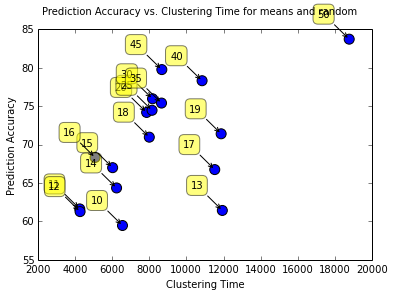

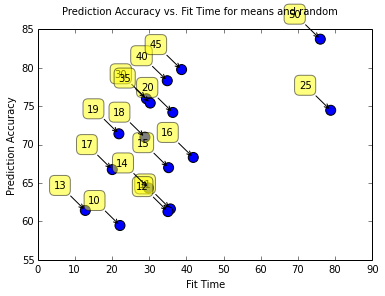

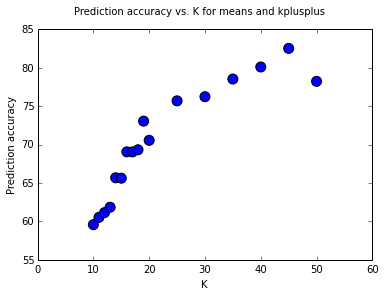

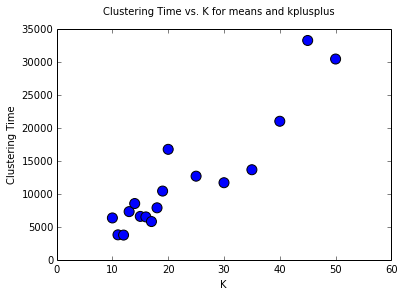

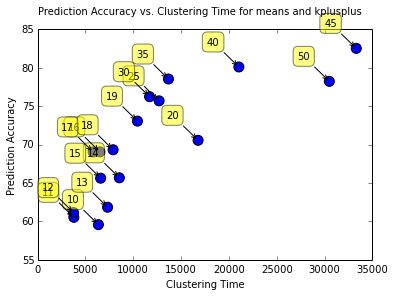

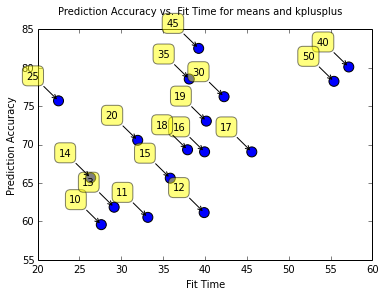

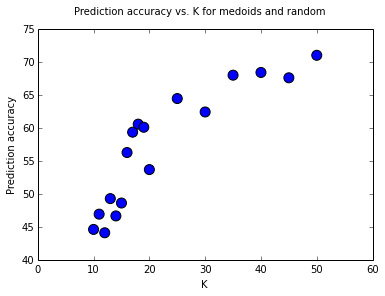

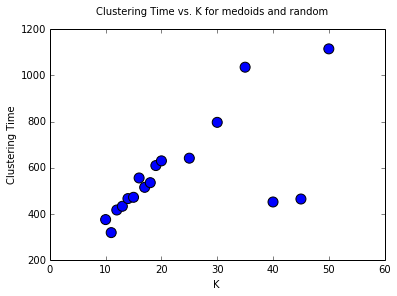

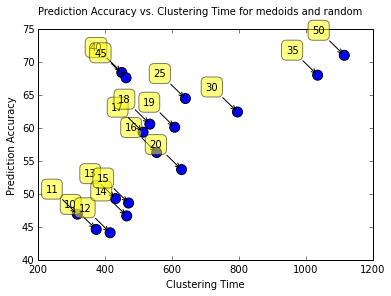

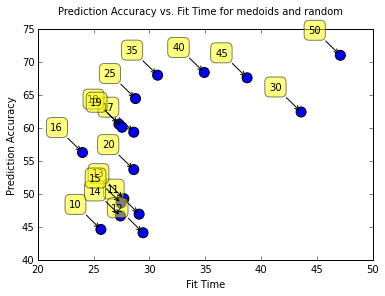

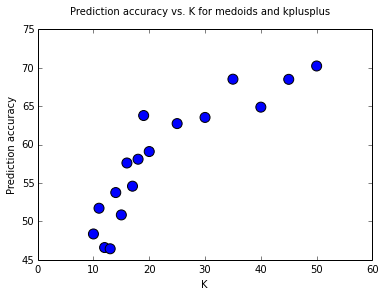

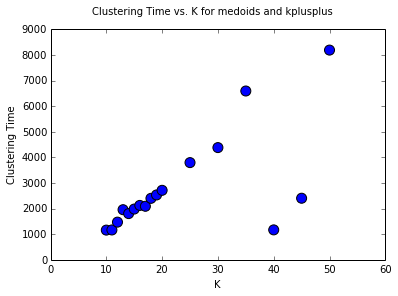

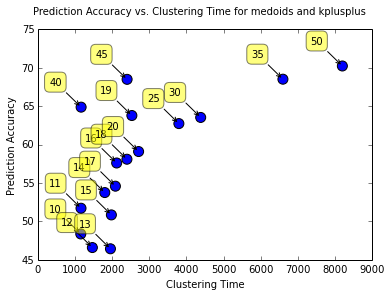

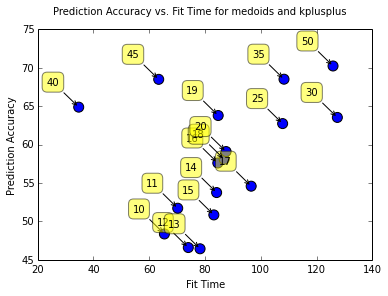

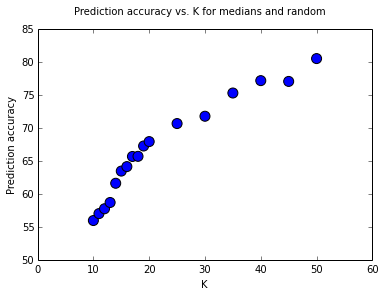

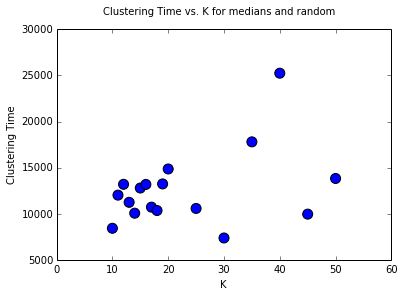

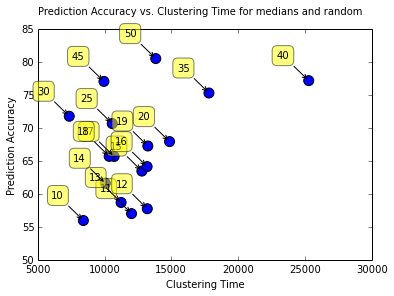

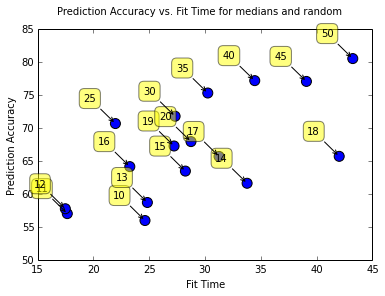

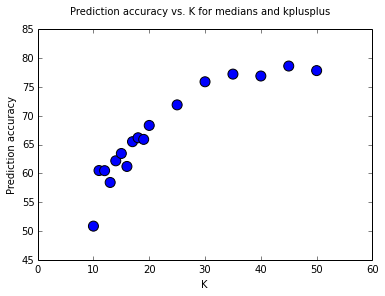

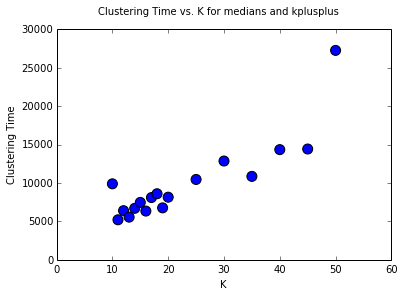

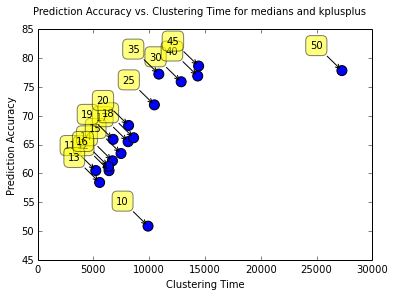

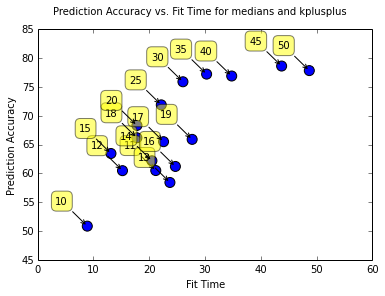

In [153]:
for m in methods:
    for init_t in init_types:
        df = results_df[(results_df.method==m) & (results_df.init_type==init_t)]
        plotset(df.k, df.prediction_accuracy, ("Prediction accuracy vs. K for %s and %s"%(m, init_t)))
        plotset(df.k, df.clustering_time, ("Clustering Time vs. K for %s and %s"%(m, init_t)))
        plotset(df.clustering_time, df.prediction_accuracy, 
                ("Prediction Accuracy vs. Clustering Time for %s and %s"%(m, init_t)), [True, df.k])
        plotset(df.testing_time, df.prediction_accuracy, 
                ("Prediction Accuracy vs. Fit Time for %s and %s"%(m, init_t)), [True, df.k])
        

In [119]:
# for m in methods:
#     for init_t in init_types:
#         df = results_df[(results_df.method==m) & (results_df.init_type==init_t)]
#         plotset(df.clustering_time, df.prediction_accuracy, 
#                 ("Prediction Accuracy vs. Clustering Time for %s and %s"%(m, init_t)), [True, df.k])

In [149]:
for m in methods:
    for init_t in init_types:
        df = results_df[(results_df.method==m) & (results_df.init_type==init_t)]
        print "The best Accuracy was: ", df.prediction_accuracy.max(), " in %s and %s"%(m, init_t)
        df = df[df.prediction_accuracy == df.prediction_accuracy.max()]
        print "And the K value was: ", df.k.max(), ", while runtime was ", df.clustering_time.max()
        print ""
        
        
print "The best Accuracy was ", results_df.prediction_accuracy.max()
df = results_df[results_df.prediction_accuracy == df.prediction_accuracy.max()]
print "And the K value was: %d" %(int(df.k.max())), " while runtime was ", df.clustering_time.max(), 

The best Accuracy was:  83.7283728373  in means and random
And the K value was:  50 , while runtime was  18753.93137

The best Accuracy was:  82.5282528253  in means and kplusplus
And the K value was:  45 , while runtime was  33317.708555

The best Accuracy was:  71.0671067107  in medoids and random
And the K value was:  50 , while runtime was  1115.51690888

The best Accuracy was:  70.2370237024  in medoids and kplusplus
And the K value was:  50 , while runtime was  8191.43628502

The best Accuracy was:  80.5680568057  in medians and random
And the K value was:  50 , while runtime was  13824.5823519

The best Accuracy was:  78.6378637864  in medians and kplusplus
And the K value was:  45 , while runtime was  14425.0948539

The best Accuracy was  83.7283728373
And the K value was: 45  while runtime was  14425.0948539
